In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import spacy
import string
import re
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence
from spacy.symbols import ORTH
from collections import Counter
from sklearn.model_selection import train_test_split

In [2]:
import os

directory = os.getcwd()
print(directory)

/content


In [3]:
cols= ['target', 'id', 'date', 'flag', 'user', 'text']
data = pd.read_csv('./drive/MyDrive/training.tweets.processed.csv', encoding='ISO-8859-1', header= None, names= cols)

In [4]:
print(data[data['text'].isnull() == True])

Empty DataFrame
Columns: [target, id, date, flag, user, text]
Index: []


In [5]:
data.shape

(1600000, 6)

In [6]:
data['text'][1599996]

'TheWDB.com - Very cool to hear old Walt interviews!  â\x99« http://blip.fm/~8bmta'

In [7]:
data['target'].unique()

array([0, 4])

In [8]:
cols_to_drop = ['id', 'date', 'flag', 'user']
data2= data.drop(columns= cols_to_drop, axis = 1)

In [9]:
data2['target'] = [0 if label == 0 else 1 for label in data['target']]

In [10]:
data2['target'].unique()

array([0, 1])

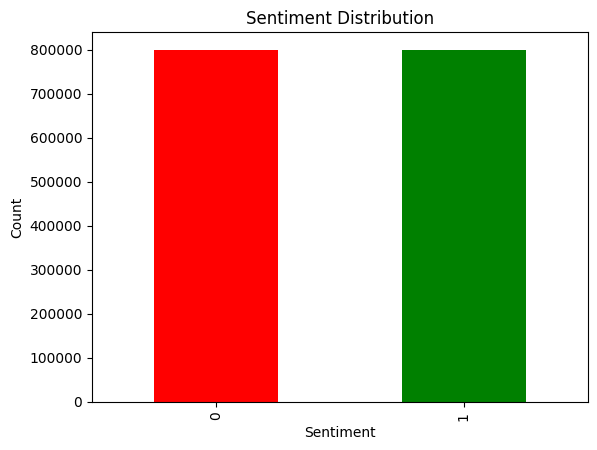

In [11]:
import matplotlib.pyplot as plt
label_counts= pd.Series(data2['target']).value_counts()
label_counts.plot(kind= 'bar', color = ['red', 'green'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [12]:
text_cleaning= re.compile(r'(@\w+)|(http\S+)|([^a-zA-Z0-9\s]|(\s+))', re.IGNORECASE)

In [13]:
my_tok= spacy.load('en_core_web_sm')

In [14]:
def my_tokenization(x, regex):
  cleaned_text = regex.sub(' ', x)
  cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
  tokens= [tok.text for tok in my_tok.tokenizer(cleaned_text)]

  return tokens

In [15]:
my_tokenization(data2['text'][1599996], text_cleaning)

['TheWDB', 'com', 'Very', 'cool', 'to', 'hear', 'old', 'Walt', 'interviews']

In [16]:
counts = Counter()
counts.update(data2['text'].apply(lambda x: my_tokenization(x, text_cleaning)).explode())

In [17]:
first_key = next(iter(counts))
first_value = counts[first_key]

In [18]:
for word in list(counts):
  if counts[word] < 5:
    del counts[word]

In [19]:
len(counts.keys())

69264

##data processing

In [20]:
vocab2index = {"": 0, "UNK": 1}
words = ["", "UNK"]
for word in counts:
  vocab2index[word] = len(words)
  words.append(word)

In [21]:
vocab2index

{'': 0,
 'UNK': 1,
 'Awww': 2,
 'that': 3,
 's': 4,
 'a': 5,
 'bummer': 6,
 'You': 7,
 'shoulda': 8,
 'got': 9,
 'David': 10,
 'Carr': 11,
 'of': 12,
 'Third': 13,
 'Day': 14,
 'to': 15,
 'do': 16,
 'it': 17,
 'D': 18,
 'is': 19,
 'upset': 20,
 'he': 21,
 'can': 22,
 't': 23,
 'update': 24,
 'his': 25,
 'Facebook': 26,
 'by': 27,
 'texting': 28,
 'and': 29,
 'might': 30,
 'cry': 31,
 'as': 32,
 'result': 33,
 'School': 34,
 'today': 35,
 'also': 36,
 'Blah': 37,
 'I': 38,
 'many': 39,
 'times': 40,
 'for': 41,
 'the': 42,
 'ball': 43,
 'Managed': 44,
 'save': 45,
 '50': 46,
 'The': 47,
 'rest': 48,
 'go': 49,
 'out': 50,
 'bounds': 51,
 'my': 52,
 'whole': 53,
 'body': 54,
 'feels': 55,
 'itchy': 56,
 'like': 57,
 'its': 58,
 'on': 59,
 'fire': 60,
 'no': 61,
 'not': 62,
 'behaving': 63,
 'at': 64,
 'all': 65,
 'i': 66,
 'm': 67,
 'mad': 68,
 'why': 69,
 'am': 70,
 'here': 71,
 'because': 72,
 'see': 73,
 'you': 74,
 'over': 75,
 'there': 76,
 'crew': 77,
 'Need': 78,
 'hug': 79,
 'hey

In [22]:
list(vocab2index.items())[0]

('', 0)

In [23]:
enc= np.zeros(150, dtype = np.int32)
enc

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [24]:
data2['text'][0]

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [25]:
x = my_tokenization(data2['text'][3], text_cleaning)

In [26]:
x

['my', 'whole', 'body', 'feels', 'itchy', 'and', 'like', 'its', 'on', 'fire']

In [27]:
encl = [vocab2index.get(w, vocab2index["UNK"]) for w in x]

In [28]:
encl

[52, 53, 54, 55, 56, 29, 57, 58, 59, 60]

In [29]:
def encode_sentence(text, vocab2index, N = 200, padding_start = True):
  if not text:
    return np.zeros(N, dtype= np.int32), 0
  x = my_tokenization(text, text_cleaning)
  enc = np.zeros(N, dtype = np.int32)
  encl = np.array([vocab2index.get(w, vocab2index["UNK"]) for w in x])
  length = min(N, len(encl))
  if padding_start:
    enc[: length] = encl[: length]
  else:
    enc[N - length: ] = encl[: length]
  return enc, length

In [30]:
text = data2['text'][3]
encode_sentence(text, vocab2index, N= 400, padding_start = False)

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0, 

In [31]:
class TwitterDataset(Dataset):
  def __init__(self, data, N = 200, padding_start = True):
    self.data = data
    self.y = self.data['target']
    self.X = self.data['text']

  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    x, s= encode_sentence(self.X.iloc[idx], vocab2index , N = 200, padding_start = False)

    return x, s, self.y.iloc[idx]

In [32]:
train_data, valid_data = train_test_split(data2, test_size = 0.2, random_state = 42)

## simple model

In [33]:
class LSTMV0Model(torch.nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim):
    super(LSTMV0Model, self).__init__()
    self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx = 0)
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first = True)
    self.linear = nn.Linear(hidden_dim, 1)
    self.dropout = nn.Dropout(0.5)

  def forward(self, x):
    x = self.embeddings(x)
    x = self.dropout(x)
    out_pack, (ht, ct) = self.lstm(x)
    return self.linear(ht[-1])

In [34]:
def train_epochs_v0(model, epochs = 10, lr = 0.001):
  parameters = filter(lambda p: p.requires_grad, model.parameters())
  optimizer = torch.optim.Adam(parameters, lr = lr)
  for i in range(epochs):
    model.train()
    sum_loss = 0.0
    total =0
    for x, s, y in train_dl:
      x = x.long().cuda()
      y = y.float().cuda()
      y_pred = model(x)
      optimizer.zero_grad()
      loss = F.binary_cross_entropy_with_logits(y_pred, y.unsqueeze(1))
      loss.backward()
      optimizer.step()
      sum_loss += loss.item() * y.shape[0]
      total += y.shape[0]
    val_loss, val_acc = val_metrics_v0(model, val_dl)
    if i % 5 == 1:
      print("train loss %.3f val loss %.3f and val accuracy %.3f" % (sum_loss / total, val_loss, val_acc))

In [35]:
def val_metrics_v0(model, val_dl):
  model.eval()
  correct = 0
  total = 0
  sum_loss = 0.0
  for x, s, y in val_dl:
    x = x.long().cuda()
    y = y.float().unsqueeze(1).cuda()
    y_hat = model(x)
    loss = F.binary_cross_entropy_with_logits(y_hat, y)
    y_pred = y_hat >0
    correct += (y_pred.float() == y).float().sum()
    total += y.shape[0]
    sum_loss += loss.item() * y.shape[0]
  return sum_loss/total, correct/ total

In [36]:
train_ds_v0 = TwitterDataset(train_data)
valid_ds_v0 = TwitterDataset(valid_data)

In [37]:
batch_size = 2000
train_dl = DataLoader(train_ds_v0, batch_size = batch_size, shuffle = True)
val_dl = DataLoader(valid_ds_v0, batch_size = batch_size)

In [38]:
vocab_size = len(words)
print(vocab_size)
model_v0 = LSTMV0Model(vocab_size, 50, 50).cuda()

69266


In [40]:
train_epochs_v0(model_v0, epochs = 10, lr = 0.001)

train loss 0.474 val loss 0.447 and val accuracy 0.795
train loss 0.423 val loss 0.418 and val accuracy 0.813


## Model Evaluations

In [41]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_v0.to(device)
valid_dl = DataLoader(valid_ds_v0, batch_size= batch_size, pin_memory = True, num_workers= 2)

In [63]:
def threshold_predictions(out, threshold= 0.5):
  return (out > threshold).float()
def evaluate_metrics(model, valid_dl, threshold= 0.5):
  model.eval()
  all_predictions = []
  all_labels = []

  with torch.no_grad():
    for x, s, y in valid_dl:
      x, s, y = x.to(device), s.to(device), y.to(device)
      logits = model(x)
      predictions = threshold_predictions(logits, threshold)
      all_predictions.extend(predictions.cpu().numpy())
      all_labels.extend(y.cpu().numpy())
    all_predictions =torch.tensor(all_predictions).to(device)
    all_labels = torch.tensor(all_labels).to(device)
    threshold= torch.FloatTensor([threshold]).to(device)
    binary_predictions = (all_predictions) > threshold.long()
    binary_labels= (all_labels > 0.5).long()

    precision = precision_score(binary_labels.cpu().numpy(), binary_predictions.cpu().numpy(), zero_division = 1)
    recall = recall_score(binary_labels.cpu().numpy(), binary_predictions.cpu().numpy())
    f1 = f1_score(binary_labels.cpu().numpy(), binary_predictions.cpu().numpy())

    return precision, recall, f1


In [64]:
precision, recall, f1 = evaluate_metrics(model_v0, valid_dl)
print(f"Precision: {precision: .4f}, Recall: {recall: .4f}, F1: {f1: .4f}")

<ipython-input-63-5dc05df72537>:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  all_predictions =torch.tensor(all_predictions).to(device)


Precision:  0.8565, Recall:  0.7515, F1:  0.8006
